## **Fig3d,f** ##

In [71]:
# 2025.10.17 Show mean FIM along rc

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from critical_bandwidth import critical_bandwidth,critical_bandwidth_m_modes

from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from scipy.integrate import quad
from scipy.stats import norm

def gini_coefficient(data):
    """计算 Gini 系数"""
    sorted_data = np.sort(data)  # 排序数据
    n = len(data)
    cumulative_sum = np.cumsum(sorted_data)  # 累计和
    sum_y = cumulative_sum[-1]  # 总和

    # Gini系数的核心公式
    gini = (2 / n) * (np.sum((np.arange(1, n + 1) * sorted_data))) / sum_y - (n + 1) / n
    return gini

# def fisher_distance(mu1, sigma1, mu2, sigma2):
#     # Calculate the Fisher distance between two 1D Gaussian distributions
#     sigma1_sq, sigma2_sq = sigma1**2, sigma2**2
#     ln_sigma_ratio = np.log(sigma1 / sigma2)
#     mean_diff_sq = (mu1 - mu2) ** 2
#     fisher_dist_sq = 2 * ln_sigma_ratio**2 + 2 * mean_diff_sq / (sigma1_sq + sigma2_sq)
#     return np.sqrt(fisher_dist_sq)

def fisher_distance(mu1, sigma1, mu2, sigma2):
    A = np.sqrt((mu1-mu2)**2/2+(sigma1+sigma2)**2)
    B = np.sqrt((mu1-mu2)**2/2+(sigma1-sigma2)**2)
    return np.sqrt(2*np.log((A+B)/(A-B))**2)

def wasserstein_distance(mu1, sigma1, mu2, sigma2):
    # Calculate the Wasserstein distance between two 1D Gaussian distributions
    mean_diff = (mu1 - mu2) ** 2
    var_diff = (sigma1 - sigma2) ** 2
    return np.sqrt(mean_diff + var_diff)


In [72]:
data_name = 'DG_bin_ppt'
# data_name = 'EG_ab_alpha'
# data_name = 'EG_ab_beta'
# data_name = 'zebrafish_dynamo_part_P2S'
# data_name = 'zebrafish_dynamo_part_P2M'
# data_name = 'zebrafish_dynamo_part_P2X'
result_path = 'FI_distribution_rc/'+data_name+'/'
mean_FIMs = np.load(result_path+'mean_FIMs.npy')

# h_crits = []

# I = (-6,-1)
# for k in range(mean_FIMs.shape[0]):
#     data = np.log2(np.diag(mean_FIMs[k]))
#     h_crit = critical_bandwidth_m_modes(data, 2, I)
#     kde = KernelDensity(kernel='gaussian', bandwidth=h_crit).fit(data.reshape(-1, 1))
#     x = np.linspace(max(np.min(data), I[0]), min(np.max(data), I[1]), 1000)
#     y = np.exp(kde.score_samples(x.reshape(-1, 1)))
#     modes = argrelextrema(np.hstack([[0], y, [0]]), np.greater)[0]
#     h_crits.append(h_crit)
#     print(x[max(modes)-1]-x[min(modes)-1])

# plt.plot(h_crits)
# # plt.savefig(result_path+'critical bandwidth.png')
# plt.show()

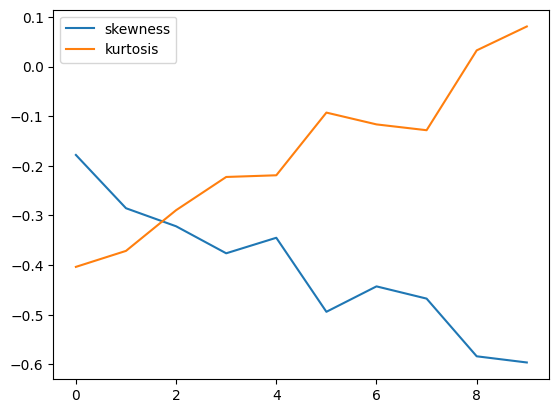

In [73]:
from scipy.stats import skew, kurtosis

skews = []
kurs = []
for k in range(len(mean_FIMs)):
    mean_FIM = mean_FIMs[k]
    skews.append(skew(-np.log10(np.diag(mean_FIM))))
    kurs.append(kurtosis(-np.log10(np.diag(mean_FIM))))

plt.plot(skews, label = 'skewness')
plt.plot(kurs, label = 'kurtosis')
plt.legend()
plt.show()

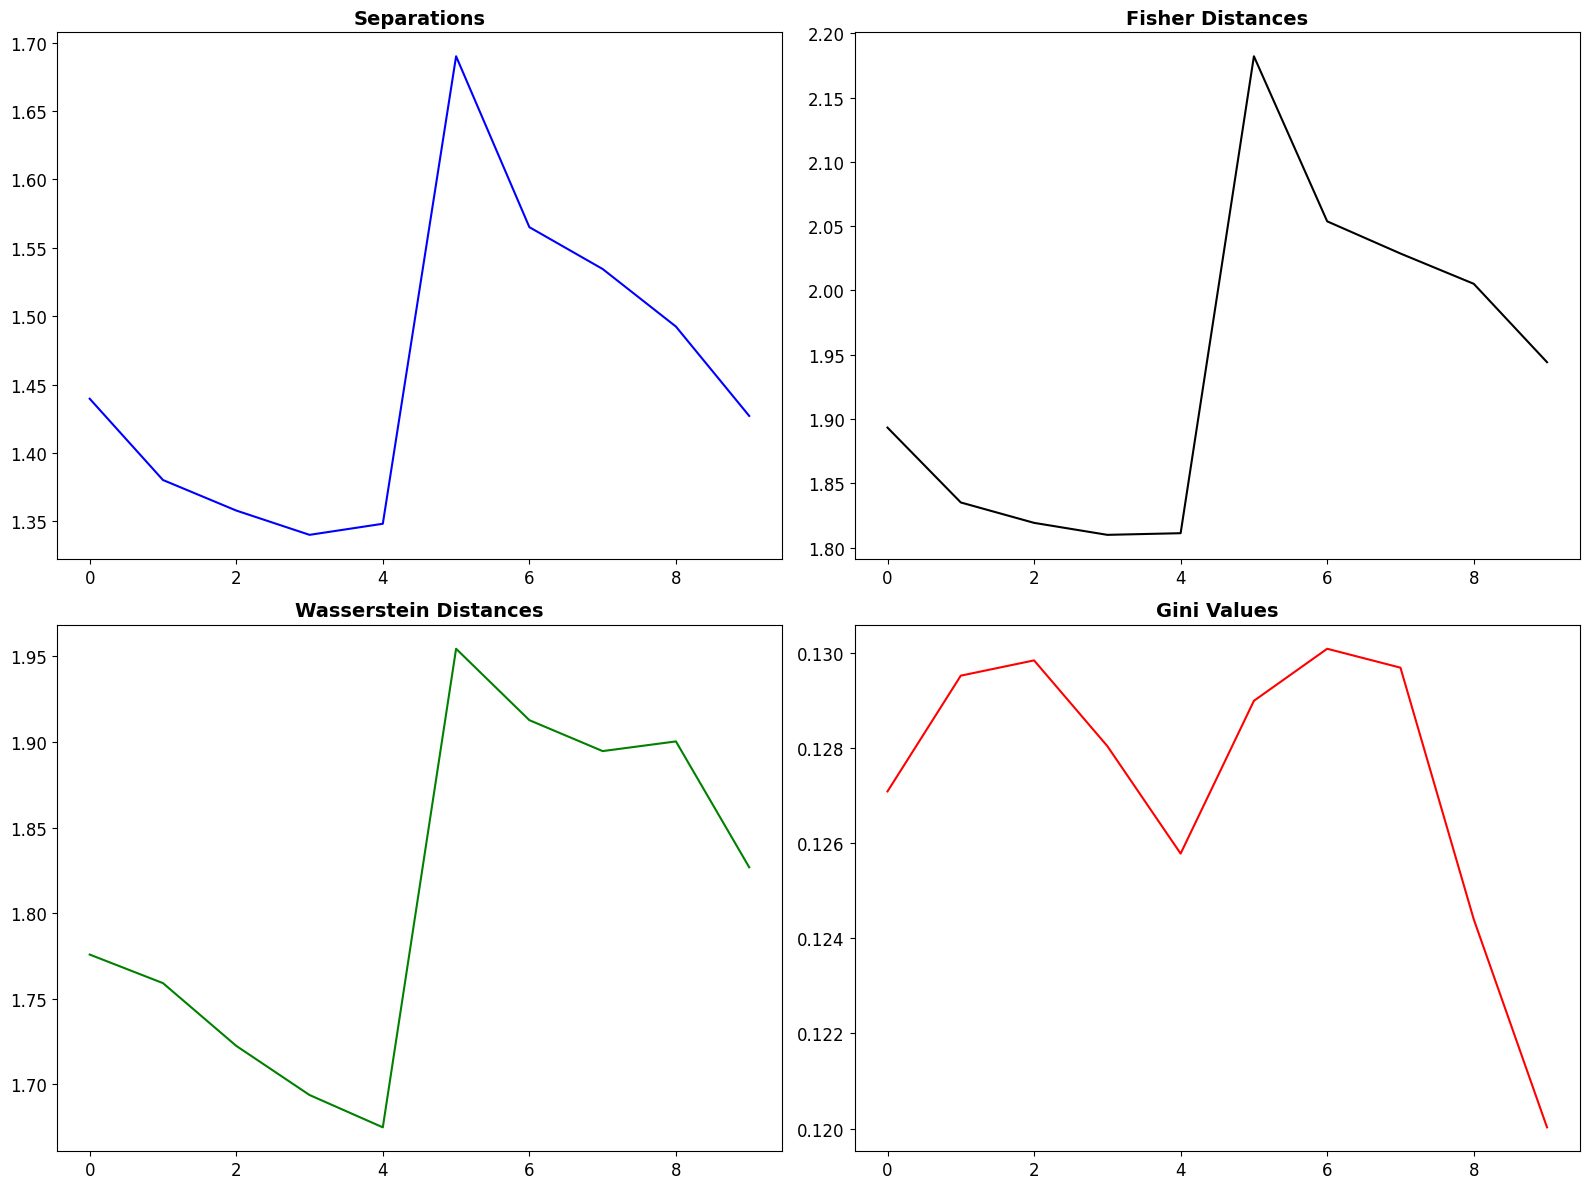

In [74]:

seeds = [42, 123, 456, 789, 1011, 2022, 3033, 4044, 5055, 6066]
N = 10

separations = []
weighted_separations = []
gini_values = []
fishers = []
wassersteins = []
dips = []
relative_overlap_areas = []
kl_divs = []

for k in range(len(mean_FIMs)):
    mean_FIM = mean_FIMs[k]

    separation = 0
    weighted_separation = 0
    fisher = 0
    wasserstein = 0
    relative_overlap_area = 0
    kl_div = 0

    
    
    for i in range(N):
        gmm = GaussianMixture(n_components=2, random_state=seeds[i])
        gmm.fit(np.log10(np.diag(mean_FIM)).reshape(-1, 1)/np.log10(5))
        means = gmm.means_.flatten()
        std= np.sqrt(gmm.covariances_).flatten()
        weights = gmm.weights_

        mu1, mu2 = means          
        sigma1, sigma2 = std         
        separation += abs(mu2 - mu1) / np.sqrt(sigma1**2 + sigma2**2)
        fisher += fisher_distance(mu1, sigma1, mu2, sigma2)
        wasserstein += wasserstein_distance(mu1, sigma1, mu2, sigma2)


        weighted_separation += abs(mu2 - mu1) / np.sqrt(sigma1**2 + sigma2**2) / abs(weights[1]-weights[0])

        kl_div += np.log(sigma1 / sigma2) + (sigma2**2 + (mu2 - mu1)**2) / (2 * sigma1**2) - 0.5
        kl_div += np.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5
        

        # #### Overlap area of 2 Gaussians
        # # Gaussian PDF
        # def gaussian_pdf(x, mean, std):
        #     return norm.pdf(x, loc=mean, scale=std)

        # # 2-GMM PDF
        # def weighted_pdf(x):
        #     pdf1 = weights[0] * gaussian_pdf(x, means[0], std[0])
        #     pdf2 = weights[1] * gaussian_pdf(x, means[1], std[1])
        #     return pdf1, pdf2

        # # Overlap of 2 Gaussian components in 2-GMM
        # def overlap_pdf(x):
        #     pdf1, pdf2 = weighted_pdf(x)
        #     return np.minimum(pdf1, pdf2)

        # # The area of 2 Gaussian component
        # overlap_area, _ = quad(overlap_pdf, -np.inf, np.inf)
        #relative_overlap_area += (min(weights[0], weights[1]) - overlap_area)/min(weights[0], weights[1])

    # print(f"均值: {means}")
    # print(f"标准差: {std}")
    # print(f"混合权重: {weights}")
    # print(f"两个峰的分离度(Separation): {separation:.3f}, 加权分离度(Separation): {weighted_separation:.3f}")

    weighted_separations.append(weighted_separation/N)
    separations.append(separation/N)
    fishers.append(fisher/N)
    wassersteins.append(wasserstein/N)
    # weighted_separations.append(weighted_separation)
    relative_overlap_areas.append(relative_overlap_area/N)
    kl_divs.append(kl_div/N)

    #########################################3
    # Gini
    gini_value = gini_coefficient(-np.log10(np.diag(mean_FIM)))
    # print(f"双峰分布的 Gini 系数: {gini_value:.3f}")
    gini_values.append(gini_value)



# 创建 2x2 的子图布局
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 字体样式参数
title_font = {'fontsize': 14, 'fontweight': 'bold'}

# 第一幅图：Separations
axs[0, 0].plot(separations, color='b')
axs[0, 0].set_title('Separations', **title_font)
axs[0, 0].tick_params(axis='both', labelsize=12)

# # 第二幅图：Overlap area
# axs[0, 1].plot(relative_overlap_areas, color='k')
# axs[0, 1].set_title('Overlap Area', **title_font)
# axs[0, 1].tick_params(axis='both', labelsize=12)

# # 第二幅图：Weighted separations
# axs[0, 1].plot(weighted_separations, color='k')
# axs[0, 1].set_title('Weighted Separations', **title_font)
# axs[0, 1].tick_params(axis='both', labelsize=12)

#第二幅图：KL-divergence(Right Gaussian || Left Gaussian)
# axs[0, 1].plot(kl_divs, color='k')
# axs[0, 1].set_title('KL-divergence', **title_font)
# axs[0, 1].tick_params(axis='both', labelsize=12)

# # 第二幅图：Fishers
axs[0, 1].plot(fishers, color='k')
axs[0, 1].set_title('Fisher Distances', **title_font)
axs[0, 1].tick_params(axis='both', labelsize=12)

# 第三幅图：Wassersteins
axs[1, 0].plot(wassersteins, color='g')
axs[1, 0].set_title('Wasserstein Distances', **title_font)
axs[1, 0].tick_params(axis='both', labelsize=12)

# 第四幅图：Gini Values
axs[1, 1].plot(gini_values, color='r')
axs[1, 1].set_title('Gini Values', **title_font)
axs[1, 1].tick_params(axis='both', labelsize=12)

# 自动调整子图间距以避免重叠
plt.tight_layout()

# plt.savefig(result_path+'peak separation.png')
# 展示图像
plt.show()

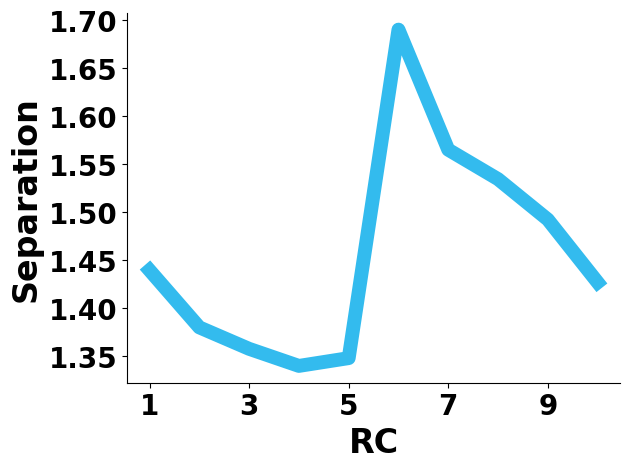

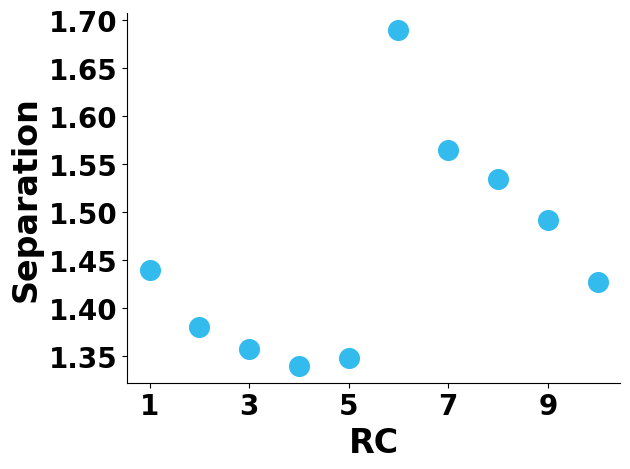

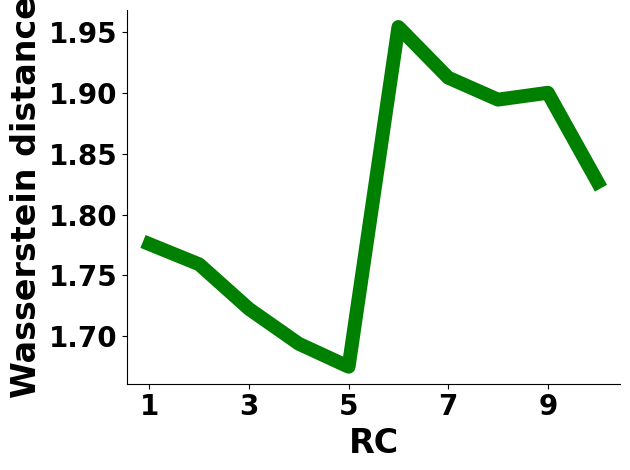

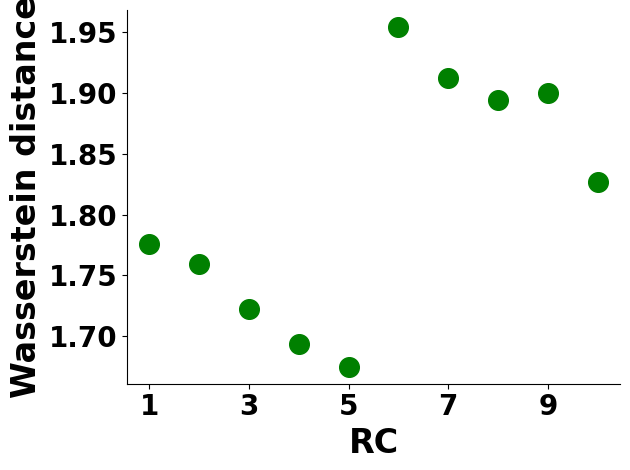

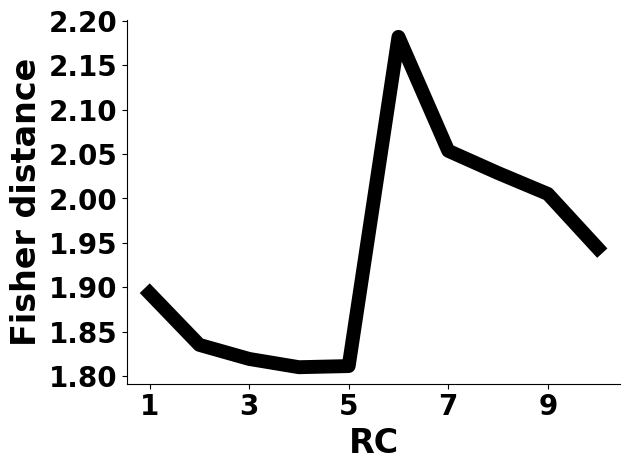

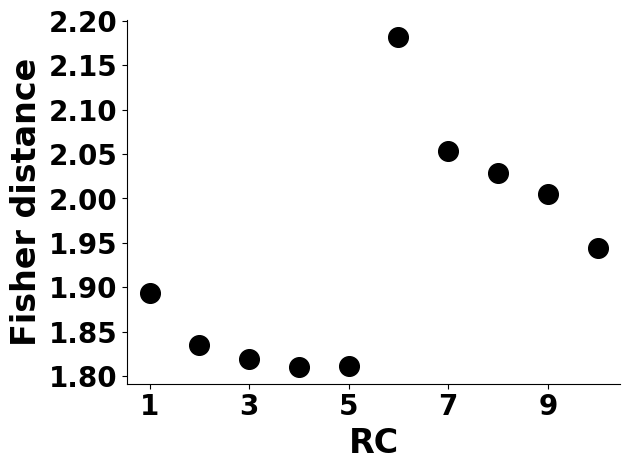

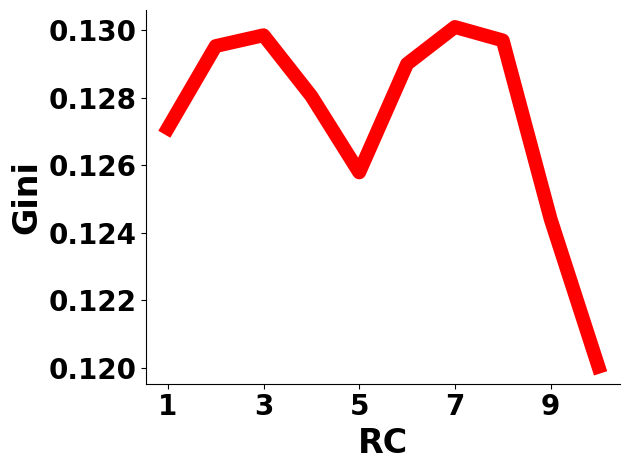

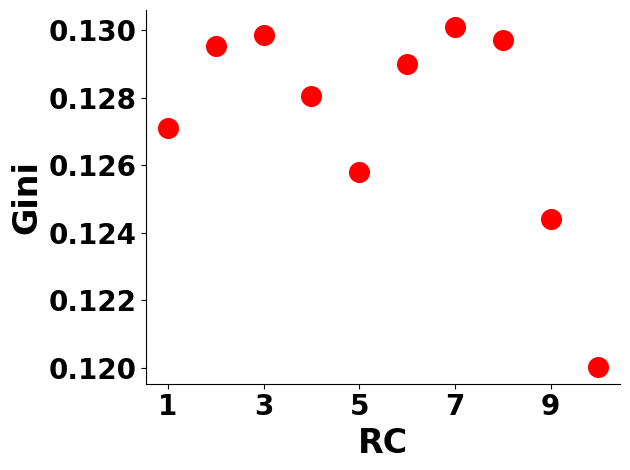

In [75]:
# 第一幅图：Separations
plt.plot(range(1, len(separations)+1), separations, color='#33BBEE', linewidth=10)
# plt.title('Separations', fontsize=18, fontweight='bold')
plt.xlabel('RC', fontsize=24, fontweight = 'bold')
plt.ylabel('Separation', fontsize=24, fontweight='bold')
num_points = len(separations)
tick_interval = num_points // 4  # 刻度间隔，根据数据长度调整
x_ticks = list(range(1, num_points + 1, tick_interval))  # 确保显示5个整数刻度
plt.xticks(ticks=x_ticks, fontsize=20, weight='bold')
plt.yticks(fontsize=20, weight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(result_path+'separation.png')
plt.show()


# 第一幅图：Separations
plt.scatter(range(1, len(separations)+1), separations, color='#33BBEE', s=200)
# plt.title('Separations', fontsize=18, fontweight='bold')
plt.xlabel('RC', fontsize=24, fontweight = 'bold')
plt.ylabel('Separation', fontsize=24, fontweight='bold')
num_points = len(separations)
tick_interval = num_points // 4  # 刻度间隔，根据数据长度调整
x_ticks = list(range(1, num_points + 1, tick_interval))  # 确保显示5个整数刻度
plt.xticks(ticks=x_ticks, fontsize=20, weight='bold')
plt.yticks(fontsize=20, weight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(result_path+'separation_dot.png')
plt.show()


# 第二幅图：Wassersteins
plt.plot(range(1, len(wassersteins)+1), wassersteins, color='g', linewidth=10)
# plt.title('Separations', fontsize=18, fontweight='bold')
plt.xlabel('RC', fontsize=24, fontweight = 'bold')
plt.ylabel('Wasserstein distance', fontsize=24, fontweight='bold')
num_points = len(separations)
tick_interval = num_points // 4  # 刻度间隔，根据数据长度调整
x_ticks = list(range(1, num_points + 1, tick_interval))  # 确保显示5个整数刻度
plt.xticks(ticks=x_ticks, fontsize=20, weight='bold')
plt.yticks(fontsize=20, weight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(result_path+'wasserstein.png')
plt.show()


# 第二幅图：Wassersteins
plt.scatter(range(1, len(wassersteins)+1), wassersteins, color='g', s=200)
# plt.title('Separations', fontsize=18, fontweight='bold')
plt.xlabel('RC', fontsize=24, fontweight = 'bold')
plt.ylabel('Wasserstein distance', fontsize=24, fontweight='bold')
num_points = len(separations)
tick_interval = num_points // 4  # 刻度间隔，根据数据长度调整
x_ticks = list(range(1, num_points + 1, tick_interval))  # 确保显示5个整数刻度
plt.xticks(ticks=x_ticks, fontsize=20, weight='bold')
plt.yticks(fontsize=20, weight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(result_path+'wasserstein_dot.png')
plt.show()


# 第三幅图：Fishers
plt.plot(range(1, len(fishers)+1), fishers, color='k', linewidth=10)
# plt.title('Separations', fontsize=18, fontweight='bold')
plt.xlabel('RC', fontsize=24, fontweight = 'bold')
plt.ylabel('Fisher distance', fontsize=24, fontweight='bold')
num_points = len(separations)
tick_interval = num_points // 4  # 刻度间隔，根据数据长度调整
x_ticks = list(range(1, num_points + 1, tick_interval))  # 确保显示5个整数刻度
plt.xticks(ticks=x_ticks, fontsize=20, weight='bold')
plt.yticks(fontsize=20, weight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(result_path+'fisher.png')
plt.show()


# 第三幅图：Fishers
plt.scatter(range(1, len(fishers)+1), fishers, color='k', s=200)
# plt.title('Separations', fontsize=18, fontweight='bold')
plt.xlabel('RC', fontsize=24, fontweight = 'bold')
plt.ylabel('Fisher distance', fontsize=24, fontweight='bold')
num_points = len(separations)
tick_interval = num_points // 4  # 刻度间隔，根据数据长度调整
x_ticks = list(range(1, num_points + 1, tick_interval))  # 确保显示5个整数刻度
plt.xticks(ticks=x_ticks, fontsize=20, weight='bold')
plt.yticks(fontsize=20, weight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(result_path+'fisher_dot.png')
plt.show()


# 第四幅图：Gini
plt.plot(range(1, len(wassersteins)+1), gini_values, color='r', linewidth=10)
# plt.title('Separations', fontsize=18, fontweight='bold')
plt.xlabel('RC', fontsize=24, fontweight = 'bold')
plt.ylabel('Gini', fontsize=24, fontweight='bold')
num_points = len(separations)
tick_interval = num_points // 4  # 刻度间隔，根据数据长度调整
x_ticks = list(range(1, num_points + 1, tick_interval))  # 确保显示5个整数刻度
plt.xticks(ticks=x_ticks, fontsize=20, weight='bold')
plt.yticks(fontsize=20, weight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(result_path+'gini.png')
plt.show()


# 第四幅图：Gini
plt.scatter(range(1, len(wassersteins)+1), gini_values, color='r', s=200)
# plt.title('Separations', fontsize=18, fontweight='bold')
plt.xlabel('RC', fontsize=24, fontweight = 'bold')
plt.ylabel('Gini', fontsize=24, fontweight='bold')
num_points = len(separations)
tick_interval = num_points // 4  # 刻度间隔，根据数据长度调整
x_ticks = list(range(1, num_points + 1, tick_interval))  # 确保显示5个整数刻度
plt.xticks(ticks=x_ticks, fontsize=20, weight='bold')
plt.yticks(fontsize=20, weight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(result_path+'gini_dot.png')
plt.show()

## **Mean Cell** ##

In [76]:
# mean_FIMs = np.load(result_path+'mean_FIMs_mean_cell.npy')

# h_crits = []

# I = (-8,0)
# for k in range(mean_FIMs.shape[0]):
#     data = np.log2(np.diag(mean_FIMs[k]))
#     h_crit = critical_bandwidth_m_modes(data, 1, I)
#     kde = KernelDensity(kernel='gaussian', bandwidth=h_crit).fit(data.reshape(-1, 1))
#     x = np.linspace(max(np.min(data), I[0]), min(np.max(data), I[1]), 1000)
#     y = np.exp(kde.score_samples(x.reshape(-1, 1)))
#     modes = argrelextrema(np.hstack([[0], y, [0]]), np.greater)[0]
#     h_crits.append(h_crit)
#     print(x[max(modes)-1]-x[min(modes)-1])

# plt.plot(h_crits)
# plt.savefig(result_path+'mean cell critical bandwidth.png')
# plt.show()

In [77]:
# seeds = [42, 123, 456, 789, 1011, 2022, 3033, 4044, 5055, 6066]
# N = 10

# separations = []
# weighted_separations = []
# gini_values = []
# fishers = []
# wassersteins = []
# dips = []
# relative_overlap_areas = []
# kl_divs = []

# for k in range(len(mean_FIMs)):
#     mean_FIM = mean_FIMs[k]

#     separation = 0
#     weighted_separation = 0
#     fisher = 0
#     wasserstein = 0
#     relative_overlap_area = 0
#     kl_div = 0

    
    
#     for i in range(N):
#         gmm = GaussianMixture(n_components=2, random_state=seeds[i])
#         gmm.fit(np.log10(np.diag(mean_FIM)).reshape(-1, 1)/np.log10(5))
#         means = gmm.means_.flatten()
#         std= np.sqrt(gmm.covariances_).flatten()
#         weights = gmm.weights_

#         mu1, mu2 = means          
#         sigma1, sigma2 = std         
#         separation += abs(mu2 - mu1) / np.sqrt(sigma1**2 + sigma2**2)
#         fisher += fisher_distance(mu1, sigma1, mu2, sigma2)
#         wasserstein += wasserstein_distance(mu1, sigma1, mu2, sigma2)


#         weighted_separation += abs(mu2 - mu1) / np.sqrt(sigma1**2 + sigma2**2) / abs(weights[1]-weights[0])

#         kl_div += np.log(sigma1 / sigma2) + (sigma2**2 + (mu2 - mu1)**2) / (2 * sigma1**2) - 0.5
#         kl_div += np.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5
        

#         # #### Overlap area of 2 Gaussians
#         # # Gaussian PDF
#         # def gaussian_pdf(x, mean, std):
#         #     return norm.pdf(x, loc=mean, scale=std)

#         # # 2-GMM PDF
#         # def weighted_pdf(x):
#         #     pdf1 = weights[0] * gaussian_pdf(x, means[0], std[0])
#         #     pdf2 = weights[1] * gaussian_pdf(x, means[1], std[1])
#         #     return pdf1, pdf2

#         # # Overlap of 2 Gaussian components in 2-GMM
#         # def overlap_pdf(x):
#         #     pdf1, pdf2 = weighted_pdf(x)
#         #     return np.minimum(pdf1, pdf2)

#         # # The area of 2 Gaussian component
#         # overlap_area, _ = quad(overlap_pdf, -np.inf, np.inf)
#         #relative_overlap_area += (min(weights[0], weights[1]) - overlap_area)/min(weights[0], weights[1])

#     # print(f"均值: {means}")
#     # print(f"标准差: {std}")
#     # print(f"混合权重: {weights}")
#     # print(f"两个峰的分离度(Separation): {separation:.3f}, 加权分离度(Separation): {weighted_separation:.3f}")

#     weighted_separations.append(weighted_separation/N)
#     separations.append(separation/N)
#     fishers.append(fisher/N)
#     wassersteins.append(wasserstein/N)
#     # weighted_separations.append(weighted_separation)
#     relative_overlap_areas.append(relative_overlap_area/N)
#     kl_divs.append(kl_div/N)

#     #########################################3
#     # Gini
#     gini_value = gini_coefficient(-np.log10(np.diag(mean_FIM)))
#     # print(f"双峰分布的 Gini 系数: {gini_value:.3f}")
#     gini_values.append(gini_value)



# # 创建 2x2 的子图布局
# fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# # 字体样式参数
# title_font = {'fontsize': 14, 'fontweight': 'bold'}

# # 第一幅图：Separations
# axs[0, 0].plot(separations, color='b')
# axs[0, 0].set_title('Separations', **title_font)
# axs[0, 0].tick_params(axis='both', labelsize=12)

# # # 第二幅图：Overlap area
# # axs[0, 1].plot(relative_overlap_areas, color='k')
# # axs[0, 1].set_title('Overlap Area', **title_font)
# # axs[0, 1].tick_params(axis='both', labelsize=12)

# # # 第二幅图：Weighted separations
# # axs[0, 1].plot(weighted_separations, color='k')
# # axs[0, 1].set_title('Weighted Separations', **title_font)
# # axs[0, 1].tick_params(axis='both', labelsize=12)

# #第二幅图：KL-divergence(Right Gaussian || Left Gaussian)
# # axs[0, 1].plot(kl_divs, color='k')
# # axs[0, 1].set_title('KL-divergence', **title_font)
# # axs[0, 1].tick_params(axis='both', labelsize=12)

# # # 第二幅图：Fishers
# axs[0, 1].plot(fishers, color='k')
# axs[0, 1].set_title('Fisher Distances', **title_font)
# axs[0, 1].tick_params(axis='both', labelsize=12)

# # 第三幅图：Wassersteins
# axs[1, 0].plot(wassersteins, color='g')
# axs[1, 0].set_title('Wasserstein Distances', **title_font)
# axs[1, 0].tick_params(axis='both', labelsize=12)

# # 第四幅图：Gini Values
# axs[1, 1].plot(gini_values, color='r')
# axs[1, 1].set_title('Gini Values', **title_font)
# axs[1, 1].tick_params(axis='both', labelsize=12)

# # 自动调整子图间距以避免重叠
# plt.tight_layout()

# # plt.savefig(result_path+'mean cell peak separation.png')
# # 展示图像
# plt.show()